In [1]:
import os
import numpy as np
import cv2
import mediapy as media
import itertools as it
from tqdm import tqdm
from sift import *
from scipy.spatial import KDTree
pi2 = np.pi*2

In [2]:
# folder = 'data/' + 'parrington'
# name = 'prtn'
folder = 'data/' + 'bridge'
name = 'IMG_'

img_name = [i for i in os.listdir(folder) if name in i]
indices = np.argsort([int(i.split('.')[0][-2:]) for i in img_name])
img_name = np.array(img_name)[indices]
imgs = [media.read_image(f"{folder}/{i}").astype(np.float32)/255 for i in img_name]

max_size = max(imgs[0].shape)
t_size = 700
resize = t_size/max_size if max_size > t_size else 0
if resize > 0:
    imgs = [cv2.resize(img, (int(img.shape[1]*resize), int(img.shape[0]*resize)))
        for img in imgs]
imgs = np.array(imgs)

gimgs = np.array([cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in imgs])


In [3]:
# media.show_images(imgs, columns=3)
# media.show_image(imgs[0])
# max_size
# imgs.shape

In [4]:
SIGMA = 1.6
S = 5
OCTAVE = 4
# idx = 5
# img = gimgs[idx]
# show = imgs[idx]
# img = rotate_image(img, 45)
# show = rotate_image(show, 45)


In [5]:
ids, ids_orig, descs = list(zip(*[SIFT(i, SIGMA=SIGMA, S=S, OCTAVE=OCTAVE, show=None, contrast_threshold=.5)
    for i in tqdm(gimgs)]))
ids = [(i[:, 2:]*(2**i[:, 0]).reshape(-1, 1)).astype(int) for i in ids_orig]
# SIFT(gimgs[0], SIGMA=SIGMA, S=S, OCTAVE=OCTAVE, show=None, contrast_threshold=.3)

  0%|          | 0/10 [00:00<?, ?it/s]Removed: 210, Remained: 2215
Removed: 66, Remained: 128
Removed: 139, Remained: 724
Removed: 70, Remained: 411
 10%|█         | 1/10 [00:04<00:38,  4.33s/it]Removed: 22, Remained: 39
Removed: 26, Remained: 63
Removed: 66, Remained: 442
Removed: 41, Remained: 407
 20%|██        | 2/10 [00:05<00:20,  2.57s/it]Removed: 0, Remained: 16
Removed: 1, Remained: 30
Removed: 116, Remained: 1437
Removed: 23, Remained: 351
 30%|███       | 3/10 [00:07<00:15,  2.27s/it]Removed: 7, Remained: 57
Removed: 0, Remained: 62
Removed: 67, Remained: 1081
Removed: 18, Remained: 424
 40%|████      | 4/10 [00:09<00:11,  1.99s/it]Removed: 3, Remained: 8
Removed: 0, Remained: 79
Removed: 114, Remained: 1294
Removed: 53, Remained: 63
 50%|█████     | 5/10 [00:10<00:09,  1.82s/it]Removed: 31, Remained: 209
Removed: 2, Remained: 113
Removed: 39, Remained: 522
Removed: 31, Remained: 471
 60%|██████    | 6/10 [00:11<00:06,  1.63s/it]Removed: 0, Remained: 21
Removed: 173, Remained

In [6]:
def queryPoints(pimg, pdesc, pids):
    tree = KDTree(pdesc[0])
    dd, ii = tree.query(pdesc[1], workers=8, k=2)
    sel = dd[:, 0] < 0.75*dd[:, 1]
    print(f"Good Matches: {sel.sum()}")
    good_queryIdx = np.where(sel)[0]
    good_trainIdx = ii[:, 0][sel]
    
    mimg = draw_matches(pimg[0], pids[0][:, ::-1], pimg[1], pids[1][:, ::-1],           good_trainIdx, good_queryIdx)
    mimg = cv2.resize(mimg, (mimg.shape[1], mimg.shape[0]))
    media.show_image(mimg, width=1024)

In [7]:
def draw_matches(img1, kp1, img2, kp2, trainIdx, queryIdx):
    if len(img1.shape) == 3:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], img1.shape[2])
    elif len(img1.shape) == 2:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1])

    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    new_img[0:img1.shape[0],0:img1.shape[1]] = img1
    new_img[0:img2.shape[0],img1.shape[1]:img1.shape[1]+img2.shape[1]] = img2
    
    r = 15
    thickness = 2
    for tid, qid in zip(*[trainIdx, queryIdx]):
        c = np.random.rand(3) if len(img1.shape) == 3 else np.random.rand(1)
        c = c.tolist()
        end1 = tuple(np.round(kp1[tid]).astype(int))
        end2 = tuple(np.round(kp2[qid]).astype(int) + np.array([img1.shape[1], 0]))
        cv2.line(new_img, end1, end2, c, thickness)
        cv2.circle(new_img, end1, r, c, thickness)
        cv2.circle(new_img, end2, r, c, thickness)

    return new_img

Good Matches: 31



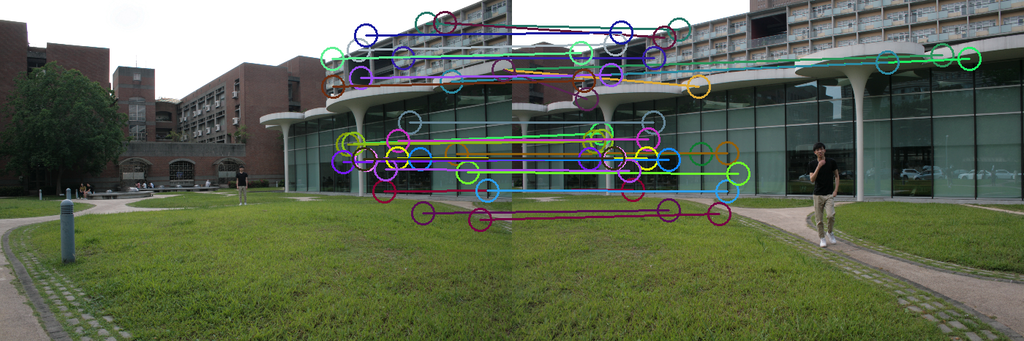

Good Matches: 22



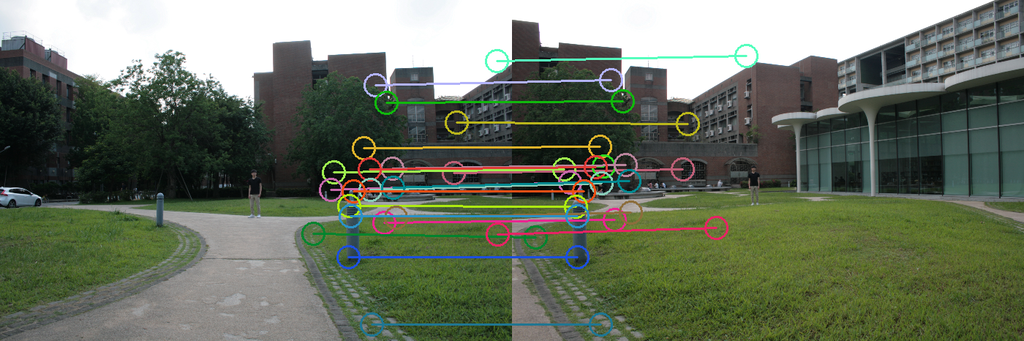

Good Matches: 18



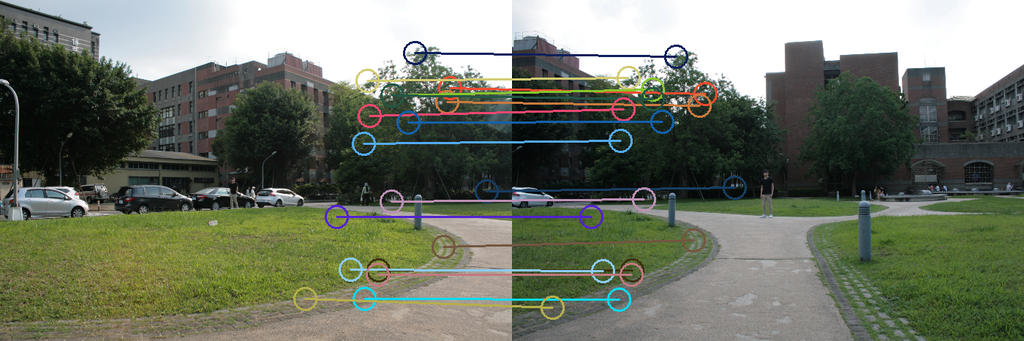

Good Matches: 20



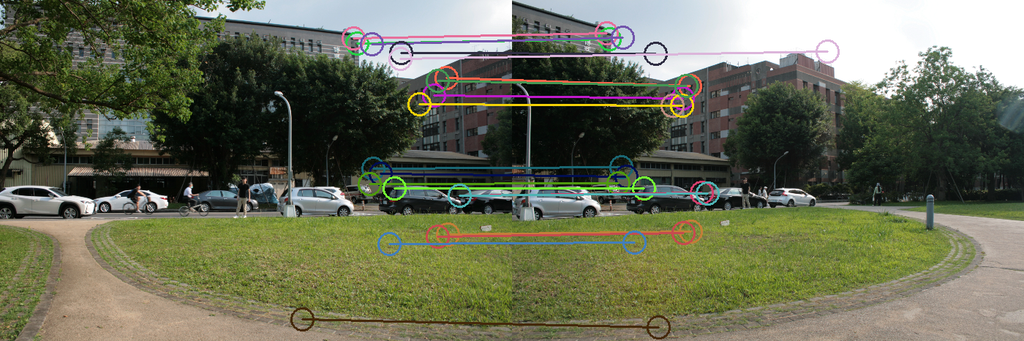

Good Matches: 12



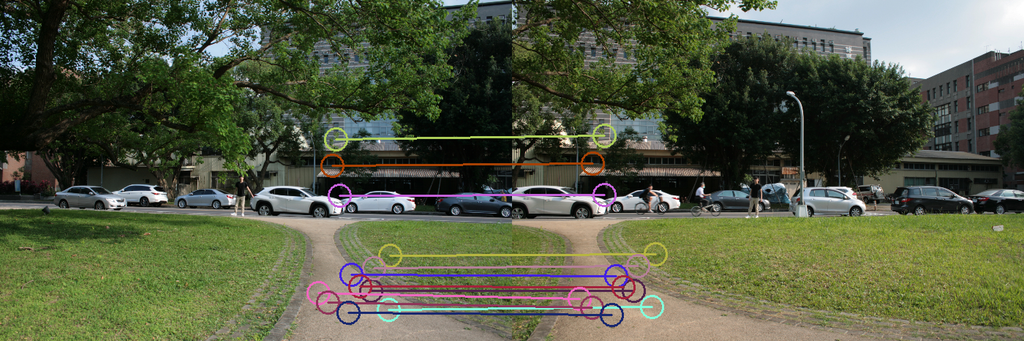

Good Matches: 12



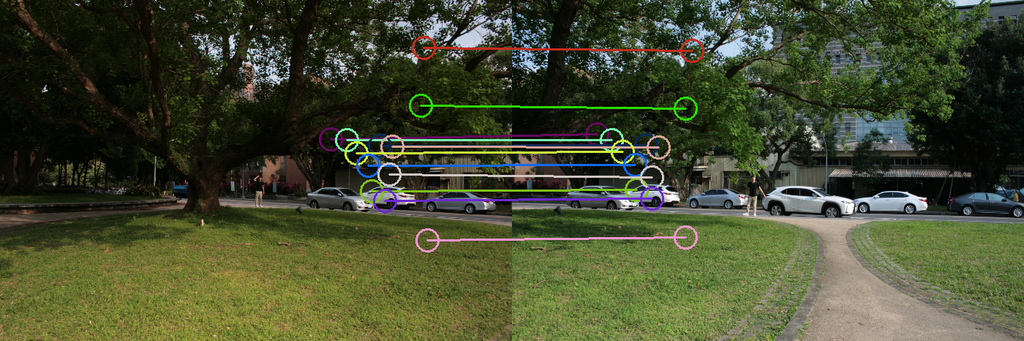

Good Matches: 1



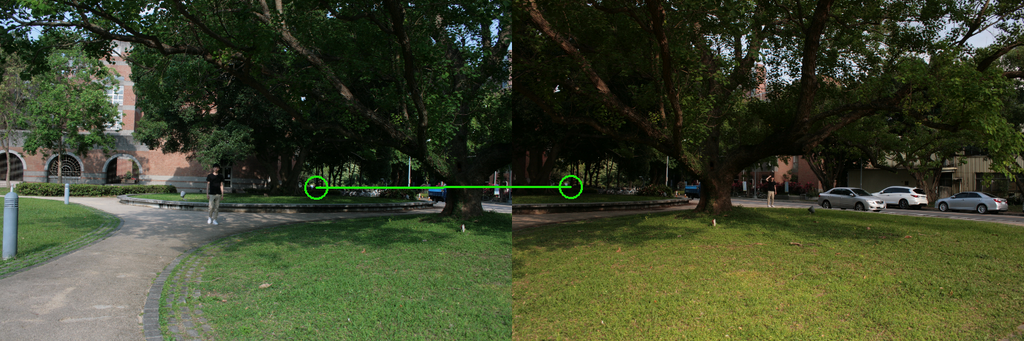

Good Matches: 6



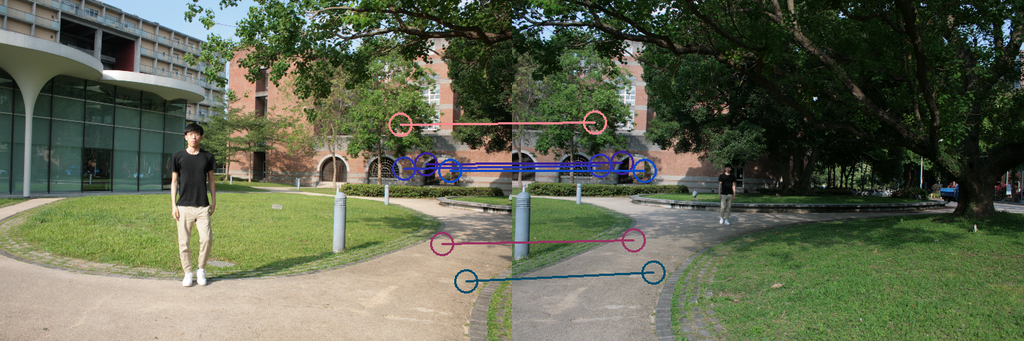

Good Matches: 7



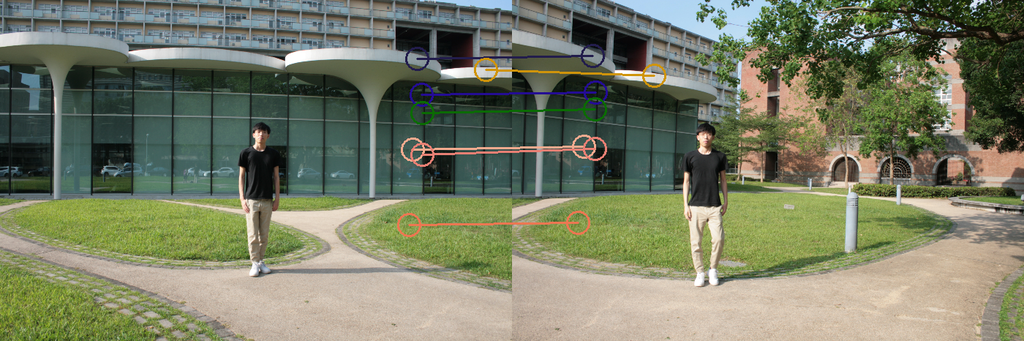

Good Matches: 11



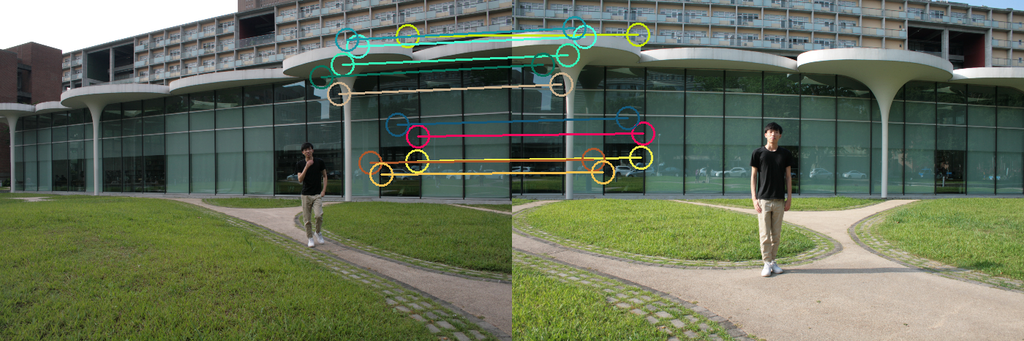

In [8]:
for i in range(len(imgs)):
    i1 = i
    i0 = (i1+1) % len(imgs)
    queryPoints([imgs[i0], imgs[i1]], [descs[i0], descs[i1]], [ids[i0], ids[i1]])